In [97]:
#DTW calculation

import pandas as pd
import numpy as np
import os
import glob 
import pickle
from math import *
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
# from quatrotate import qv_mult # this routine implements rotation via quaternion multiplication

%matplotlib inline

In [31]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(20,4))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [32]:
# Function to map the colors as a list from the input list of x variables
def color_mapping(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [33]:
def GaussianFilter(df, window_length):
    df1 = df
    
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    df1['AX1'] = gaussian_filter(df['AX1'], window_length)
    df1['AY1'] = gaussian_filter(df['AY1'], window_length)
    df1['AZ1'] = gaussian_filter(df['AZ1'], window_length)

    df1['GX1'] = gaussian_filter(df['GX1'], window_length)
    df1['GY1'] = gaussian_filter(df['GY1'], window_length)
    df1['GZ1'] = gaussian_filter(df['GZ1'], window_length)
    return df1

In [34]:
def Amplitude(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]]**2 + df[input_features[1]]**2  + df[input_features[2]]**2)**(1/2)
  
    

In [35]:
def Yaw_Roll_Pitch(df):
    roll  = []
    pitch = []
    yaw   = []
    for i in range(len(df)):
        x = df['AX'][i]
        y = df['AY'][i]
        z = df['AZ'][i]
        roll1 = atan(y/z)*57.3
        pitch1= atan((-x/(y*y + z*z)**(1/2)))*57.3
        yaw1  = atan((z/((x*x + z*z)**(1/2))))*57.3
        
        roll.append(roll1)
        pitch.append(pitch1)
        yaw.append(yaw1)
    
    df['orientX'] = pitch
    df['orientY'] = roll
    df['orientZ'] = yaw

In [36]:
def getQuat(df):

        """ Given 3 orientation angles, compute the quaternion. """

        yaw   = df['orientZ'] / 2. * np.pi / 180
        roll  = df['orientX'] / 2. * np.pi / 180
        pitch = df['orientY'] / 2. * np.pi / 180

        w =  np.cos(roll) * np.cos(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.sin(pitch) * np.sin(yaw)

        x =  np.sin(roll) * np.cos(pitch) * np.cos(yaw) - \
                np.cos(roll) * np.sin(pitch) * np.sin(yaw)

        y =  np.cos(roll) * np.sin(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.cos(pitch) * np.sin(yaw)

        z =  np.cos(roll) * np.cos(pitch) * np.sin(yaw) - \
                np.sin(roll) * np.sin(pitch) * np.cos(yaw)

        return w, x, y, z

In [37]:
"""
Rotate a 3D vector using the axis-angle method (quaternions).
"""

import numpy as np


def normalize(v, tolerance=0.00001):
    mag2 = sum(n * n for n in v)
    if abs(mag2 - 1.0) > tolerance:
        mag = np.sqrt(mag2)
        v = tuple(n / mag for n in v)
    return v

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def axisangle_to_q(v, theta):
    v = normalize(v)
    x, y, z = v
    theta /= 2
    w = np.cos(theta)
    x = x * np.sin(theta)
    y = y * np.sin(theta)
    z = z * np.sin(theta)
    return w, x, y, z

def q_to_axisangle(q):
    w, v = q[0], q[1:]
    theta = np.acos(w) * 2.0
    return normalize(v), theta

In [38]:
def get_rotation(quatern, vector):
    rotaedvector = []
    for i in range(vector.shape[0]):
        rotaedvector.append(qv_mult(tuple(quatern[i,:]), tuple(vector[i,:])))
    return np.array(rotaedvector)

In [39]:
def rotate(df):
    features = ['A', 'G']
    quaternion = df[['quaternionW', 'quaternionX',
                     'quaternionY','quaternionZ']].values
    
    for f in features:
        xyzlist = [f + 'X', f + 'Y', f + 'Z']
        xyz = df[xyzlist].values
        xyz_rotated = get_rotation(quaternion, xyz)
        df[f + 'X1'] = xyz_rotated[:,0]
        df[f + 'Y1'] = xyz_rotated[:,1]
        df[f + 'Z1'] = xyz_rotated[:,2]
        

In [40]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT(df, input_features, output_features):
    
    for i in range(len(input_features)):
        reals = np.real(np.fft.rfft(df[input_features[i]]))
        imagn = np.imag(np.fft.rfft(df[input_features[i]]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
        if( len(df) > len(complexs)):
            complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
            
        df[output_features[i]] = complexs
    return df

In [41]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        gx = df['GX1'].values[i: i + N_TIME_STEPS]
        gy = df['GY1'].values[i: i + N_TIME_STEPS]
        gz = df['GZ1'].values[i: i + N_TIME_STEPS]
        
        ax = df['AX1'].values[i: i + N_TIME_STEPS]
        ay = df['AY1'].values[i: i + N_TIME_STEPS]
        az = df['AZ1'].values[i: i + N_TIME_STEPS]
        
        fax = df['fAX'].values[i: i + N_TIME_STEPS]
        fay = df['fAY'].values[i: i + N_TIME_STEPS]
        faz = df['fAZ'].values[i: i + N_TIME_STEPS]
        
        ma = df['mAcc'].values[i: i + N_TIME_STEPS]
        mz = df['mGyro'].values[i: i + N_TIME_STEPS]
        label = "ST"
        segments.append([gx, gy, gz, ax, ay, az, ma, mz, fax, fay, faz])
#         labels = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        labels.append(label)
    return segments, labels

In [42]:
def DTWDistance(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return (DTW[len(s1)-1, len(s2)-1])**(1/2)

In [43]:
def loss_for_segments(segments, comp, feature):
    loss =[]
    labels=[]
    length = len(segments)
    for i in range(length):
        x = segments[i][feature]        
        dist = DTWDistance(x, comp, 50)
#         print(i , '=>', dist)
        loss.append(dist)
    
    return loss

In [44]:
def data_preprocessing(df):
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    Amplitude(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX', 'GY', 'GZ']
    output_feature = 'mGyro'
    Amplitude(df, input_features, output_feature)
    
    #Re-Orientation of 3-axis acc. and gyro sensor data
    Yaw_Roll_Pitch(df)
    qw, qx, qy, qz = getQuat(df)
    df['quaternionW'] = qw
    df['quaternionX'] = qx
    df['quaternionY'] = qy
    df['quaternionZ'] = qz
    rotate(df)
    #apply gaussian filter with window size 10
    df = GaussianFilter(df, 10)

    #Frequency domain feature generation from time series accelerometer data
    input_features = ['AX1', 'AY1', 'AZ1']
    output_feature = ['fAX', 'fAY', 'fAZ']
    df = FFT(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series gyroscope data
    input_features = ['AX1', 'AY1', 'AZ1']
    output_feature = ['fGX', 'fGY', 'fGZ']
    df = FFT(df, input_features, output_feature)
    
    return df

In [45]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [46]:
def read_files(acc_file, gyro_file, activity):
    df = read_csv_file(acc_file, gyro_file, activity)
    df.reset_index(drop = True , inplace = True)
    if('Milliseconds' in df.columns):
        df = df.drop('Milliseconds', axis=1)
    if('Timestamp' in df.columns):
        df = df.drop('Timestamp', axis=1)

    df = data_preprocessing(df)
    
    return df
    

In [48]:
  
path_acc = os.getcwd() + '/data/bike/*/*/*Accelerometer.csv'  
path_gyro= os.getcwd() + '/data/bike/*/*/*Gyroscope.csv'  
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
bike_df= read_files(acc_files[0], gyro_files[0], 'bike')
n = len(bike_df)
bike_df = bike_df[500:n-500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'bike')
    n = len(df_this)
    print("len of this file ",df_this.shape)
    df_this = df_this[350 : n-500]
    print("len of this file ",df_this.shape)
    bike_df = pd.concat([bike_df, df_this])
    print(bike_df.shape)
bike_df.reset_index(drop = True, inplace = True)
bike_df.head()


/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike0903/2018-09-03_16-06-48/Accelerometer.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike0903/2018-09-03_16-06-48/Gyroscope.csv
len of this file  (296, 28)
len of this file  (0, 28)
(0, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike0903/2018-09-03_15-58-17/Accelerometer.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike0903/2018-09-03_15-58-17/Gyroscope.csv
len of this file  (11542, 28)
len of this file  (10692, 28)
(10692, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike0903/2018-09-03_16-12-17/Accelerometer.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike0903/2018-09-03_16-12-17/Gyroscope.csv
len of this file  (10027, 28)
len of this file  (9177, 28)
(19869, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike0903/2018-09-03_15-53-27/Accelerometer.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike0903/2018-09-03_15-53-27/Gyroscope

,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,orientX,...,AZ1,GX1,GY1,GZ1,fAX,fAY,fAZ,fGX,fGY,fGZ
0,7.460085,-0.465215,-6.659244,-0.133173,-0.076351,0.104627,bike,10.636006,0.355847,-47.395713,...,-4.590110,-0.082149,0.089859,0.134064,86.058397,-159.980622,25.947229,86.058397,-159.980622,25.947229
1,7.452273,-0.433641,-6.664484,-0.141457,-0.077701,0.103369,bike,10.767709,0.379878,-46.602038,...,-4.585738,-0.090293,0.093288,0.134555,-90.213558,96.536584,-67.436650,-90.213558,96.536584,-67.436650
2,7.445477,-0.399441,-6.667991,-0.148915,-0.078951,0.101645,bike,10.719359,0.369426,-43.339614,...,-4.578397,-0.097998,0.096087,0.134522,-9.293082,-244.228289,-153.633644,-9.293082,-244.228289,-153.633644
3,7.439853,-0.362867,-6.669897,-0.155505,-0.080184,0.099483,bike,10.347442,0.343799,-46.065108,...,-4.568265,-0.105249,0.098195,0.134042,-124.756576,49.903874,-55.312569,-124.756576,49.903874,-55.312569
4,7.435473,-0.324261,-6.670382,-0.161207,-0.081489,0.096916,bike,8.139410,0.342391,-40.143515,...,-4.555631,-0.112046,0.099570,0.133198,114.331420,-136.567513,-29.173003,114.331420,-136.567513,-29.173003


In [49]:
print(bike_df.shape)
bike_df.columns

(54952, 28)


Index(['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ', 'activity', 'mAcc', 'mGyro',
       'orientX', 'orientY', 'orientZ', 'quaternionW', 'quaternionX',
       'quaternionY', 'quaternionZ', 'AX1', 'AY1', 'AZ1', 'GX1', 'GY1', 'GZ1',
       'fAX', 'fAY', 'fAZ', 'fGX', 'fGY', 'fGZ'],
      dtype='object')

In [50]:
bike_segments, bike_labels = segmentation(bike_df, 400)
np.array(bike_segments).shape

(1092, 11, 400)

In [51]:
def DTWdistance(segments, ref):
    y = segments
    DTW_list = []
    for i in range(len(segments[1])):
        x = ref
        print("calculating loss for feature ", i, "....")
        diff = loss_for_segments(y, x, i)
        print("Done")
        DTW_list.append(diff)
    
    return DTW_list  

In [52]:
ref  = [0.0]*400
len(ref)

400

In [61]:
bike_dtw_data = DTWdistance(bike_segments, ref)

calculating loss for feature  0 ....
Done
calculating loss for feature  1 ....
Done
calculating loss for feature  2 ....
Done
calculating loss for feature  3 ....
Done
calculating loss for feature  4 ....
Done
calculating loss for feature  5 ....
Done
calculating loss for feature  6 ....
Done
calculating loss for feature  7 ....
Done
calculating loss for feature  8 ....
Done
calculating loss for feature  9 ....
Done
calculating loss for feature  10 ....
Done


In [59]:
bike_dtw_data[6]

NameError: name 'bike_dtw_data' is not defined

In [62]:
print(np.array(bike_dtw_data).shape)
bike_dtw_data = [*zip(*bike_dtw_data)]
print(np.array(bike_dtw_data).shape)

(11, 1092)
(1092, 11)


In [63]:
import csv
with open("test_data_bike.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(bike_dtw_data)

In [54]:
path_acc = os.getcwd() + '/data/car1/*/*/*Accelerometer.csv'  
path_gyro= os.getcwd() + '/data/car1/*/*/*Gyroscope.csv'
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
car_df= read_files(acc_files[0], gyro_files[0], 'car')
n = len(car_df)
car_df = car_df[350:n-500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'car')
    n = len(df_this)
    print("len of this file ",df_this.shape)
    df_this = df_this[350 : n-500]
    print("len of this file ",df_this.shape)
    car_df = pd.concat([car_df, df_this])
    print(car_df.shape)
car_df.reset_index(drop = True, inplace = True)
car_df.head()

/home/vicky/Desktop/Dhananjay/human-activity/data/car1/car/2018-08-17_16-43-04/Accelerometer.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/car1/car/2018-08-17_16-43-04/Gyroscope.csv
len of this file  (6633, 28)
len of this file  (5783, 28)
(11566, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/car1/car/2018-08-17_16-54-34/Accelerometer.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/car1/car/2018-08-17_16-54-34/Gyroscope.csv
len of this file  (324, 28)
len of this file  (0, 28)
(11566, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/car1/car/2018-08-17_16-45-30/Accelerometer.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/car1/car/2018-08-17_16-45-30/Gyroscope.csv
len of this file  (6759, 28)
len of this file  (5909, 28)
(17475, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/car1/car/2018-08-17_16-54-46/Accelerometer.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/car1/car/2018-08-17_16-54-46/Gyroscope.csv
len of this file  (5282, 28)
len o

,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,orientX,...,AZ1,GX1,GY1,GZ1,fAX,fAY,fAZ,fGX,fGY,fGZ
0,0.247499,2.093523,9.433681,0.034840,0.137716,0.332758,car,9.660245,0.233839,-6.705914,...,9.076054,-0.028549,0.157783,0.305277,-0.992960,-13.642679,16.519178,-0.992960,-13.642679,16.519178
1,0.256934,2.088005,9.437702,0.035408,0.116555,0.339397,car,10.634199,0.218887,1.288556,...,9.078909,-0.013321,0.146258,0.312567,5.063881,-62.618469,17.343264,5.063881,-62.618469,17.343264
2,0.270615,2.082898,9.441708,0.035289,0.096402,0.342103,car,9.641014,0.223861,5.685150,...,9.079089,0.000273,0.134272,0.316113,-2.220923,-6.601487,31.955281,-2.220923,-6.601487,31.955281
3,0.287898,2.078020,9.445900,0.034548,0.077432,0.341075,car,8.737033,0.637923,11.594291,...,9.077270,0.012192,0.122009,0.316102,2.214610,14.276642,27.534206,2.214610,14.276642,27.534206
4,0.308164,2.073208,9.450460,0.033261,0.059779,0.336601,car,10.103459,0.835866,-4.875435,...,9.074090,0.022444,0.109646,0.312812,-1.598066,9.676030,-10.303919,-1.598066,9.676030,-10.303919


In [55]:
print(car_df.shape)
car_df.columns

(49174, 28)


Index(['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ', 'activity', 'mAcc', 'mGyro',
       'orientX', 'orientY', 'orientZ', 'quaternionW', 'quaternionX',
       'quaternionY', 'quaternionZ', 'AX1', 'AY1', 'AZ1', 'GX1', 'GY1', 'GZ1',
       'fAX', 'fAY', 'fAZ', 'fGX', 'fGY', 'fGZ'],
      dtype='object')

In [56]:
car_segments, car_labels = segmentation(car_df, 400)
np.array(car_segments).shape

(976, 11, 400)

In [57]:
car_dtw_data = DTWdistance(car_segments, ref)

calculating loss for feature  0 ....
Done
calculating loss for feature  1 ....
Done
calculating loss for feature  2 ....
Done
calculating loss for feature  3 ....
Done
calculating loss for feature  4 ....
Done
calculating loss for feature  5 ....
Done
calculating loss for feature  6 ....
Done
calculating loss for feature  7 ....
Done
calculating loss for feature  8 ....
Done
calculating loss for feature  9 ....
Done
calculating loss for feature  10 ....
Done


In [58]:
print(np.array(car_dtw_data).shape)
car_dtw_data = [*zip(*car_dtw_data)]
print(np.array(car_dtw_data).shape)

(11, 976)
(976, 11)


In [201]:
import csv
with open("test_data_car.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(car_dtw_data)

In [98]:
train1 = pd.read_csv('test_data_car.csv').values.tolist()
train2 = pd.read_csv('test_data_bike.csv').values.tolist()
train3 = pd.read_csv('train_bike.csv').values.tolist()
train4 = pd.read_csv('train_car.csv').values.tolist()
print(len(train1))
print(len(train2))
print(len(train3))
print(len(train4))


977
1091
1503
1398


In [99]:
train11 = [*zip(*train1)]

In [100]:

label1 = [1]*(len(train1)+len(train4))     #lebel = 1 to all bike samples

label2 = [0]*(len(train2)+len(train3))     #lebel = 0 to all car samples

label = label1 + label2                    #putting both lables into one label

train = train1 + train2 + train3 + train4


In [101]:
len(train)

4969

In [102]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=RANDOM_SEED)

In [103]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))


3975
3975
994
994


In [104]:
xx = np.array(X_train)
X_train1 = xx[:,6:8]

In [105]:
# apply svm model
print("---------SVM model---------\n")
svm_clf = svm.SVC(kernel='rbf')

# get the 5-fold cross-validation score



---------SVM model---------



In [106]:
print("cross-validation score \n")
scores = cross_val_score(svm_clf, X_train1, y_train, cv=5)
print(scores, scores.mean(), scores.std())

# apply model to test set
svm_clf.fit(X_train1, y_train)

cross-validation score 

[ 0.87437186  0.89559748  0.89433962  0.89056604  0.90428212] 0.891831423964 0.0098176534924


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [8]:
print("cross-validation score \n")
scores = cross_val_score(svm_clf, X_train, y_train, cv=5)
print(scores, scores.mean(), scores.std())

# apply model to test set
svm_clf.fit(X_train, y_train)
svm_predict_y = svm_clf.predict(X_test)
print("\n")
# obtain accuracy score
svm_predict_y = svm_clf.predict(X_test)
testscore = accuracy_score(y_test, svm_predict_y)
print("Accuracy score on test set: %6.3f" % testscore)


cross-validation score 

[ 0.91080402  0.91698113  0.92201258  0.92704403  0.91057935] 0.917484220208 0.00639455036899


Accuracy score on test set:  0.919


In [9]:
svm_clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
X = pd.Series(X_train)

0

NameError: name 'red_dot' is not defined

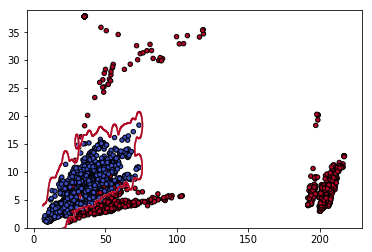

In [109]:
h = .02  # step size in the mesh
# create a mesh to plot in
X = np.array(X_train1)
x_min, x_max = X[:,0].min()-1, X[:,0].max() + 1
y_min, y_max =X[:,1].min()-1, X[:,1].max() + 1

# print(x_min)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))



# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, cmap=plt.cm.coolwarm)
plt.scatter(X[:,0], X[:,1], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
# plt.legend([red_dot, (blue_dot)], ["Bike", "Car"])
plt.xlabel("Amplitude of 3-axis accelerometer(m/s^2)")
plt.ylabel("Amplitude of 3-axis gyroscope(rad/s)")
plt.show()

In [29]:

# train a random forest
print("---------Random-Forest---------\n")
rf_clf = RandomForestClassifier(n_estimators=350)
# get the 5-fold cross-validation score
print("cross-validation score \n")
scores = cross_val_score(rf_clf, X_train, y_train, cv=5)
print(scores, scores.mean(), scores.std())

# apply model to test set
rf_clf.fit(X_train, y_train)
rf_predict_y = rf_clf.predict(X_test)

print("\n")
# obtain accuracy score
testscore = accuracy_score(y_test, rf_predict_y)
print("Accuracy score on test set: %6.3f" % testscore)


---------Random-Forest---------

cross-validation score 

[ 0.91353383  0.92230576  0.93467337  0.94346734  0.92211055] 0.927218171056 0.010555528371


Accuracy score on test set:  0.930


In [141]:
def saveModel(model, path):
    list_pickle = open(path, 'wb')
    pickle.dump(model, list_pickle)
    list_pickle.close()

In [146]:
def unpickleModel(path):
    unpickle = open(path, 'rb')
    model = pickle.load(unpickle)
    
    return model
    

In [143]:
saveModel(svm_clf, 'svm_model3.pkl')
saveModel(rf_clf, 'rf_model3.pkl')

In [144]:
pickle_path = 'svm_model3.pkl'
unpickle = open(pickle_path, 'rb')

grd_bst = pickle.load(unpickle)
pred_grd = grd_bst.predict(X_test)
# pred_grd = le.inverse_transform(pred_grd)
accuracy_grd = accuracy_score(pred_grd,y_test)
print('accuracy using svm model1 : ',accuracy_grd)

accuracy using svm model1 :  0.809428284855


In [22]:
pickle_path = 'rf_model2.pkl'
unpickle = open(pickle_path, 'rb')

grd_bst = pickle.load(unpickle)
pred_grd = grd_bst.predict(X_test)
# pred_grd = le.inverse_transform(pred_grd)
accuracy_grd = accuracy_score(pred_grd,y_test)
print('accuracy using svm model1 : ',accuracy_grd)

accuracy using svm model1 :  0.929789368104
